Program to suggest find similar music based on various parameters. Performing this unsupervised learning.


In [21]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
import hdbscan

In [2]:
data = pd.read_csv('spotify-tracks.csv')

In [3]:
data.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
data = data.drop_duplicates()
data = data.dropna()

In [5]:
data['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [ ]:
data['track_genre'].value_counts()

,count
track_genre,
acoustic,1000
afrobeat,1000
psych-rock,1000
progressive-house,1000
power-pop,1000
...,...
emo,1000
electronic,1000
electro,1000


In [12]:
df = data.drop(['track_id','artists', 'album_name', 'track_name'], axis=1)

I'm going to be taking a sample of 250 tracks from each genre, and try to hierarchical cluster. If that works I'll use that to get a 'k' that will be used for k-means. and compare it with regular k-means. Goal is to find if the k from hierarchical matches the best result from k-means.

In [6]:
scaler = StandardScaler()

In [7]:
scaler = make_pipeline(MinMaxScaler())

In [8]:
ohe = make_pipeline(OneHotEncoder(sparse_output=False))

In [13]:
preprecessing = make_column_transformer(
    (scaler, ['popularity', 'duration_ms', 'key', 'loudness', 'tempo']),
    (ohe, ['time_signature']),
    remainder='passthrough'
)

In [14]:
transformed_df = preprecessing.fit_transform(df)
transformed_df

array([[0.73, 0.04247319940734892, 0.09090909090909091, ..., 0.358,
        0.715, 'acoustic'],
       [0.55, 0.026971093629421718, 0.09090909090909091, ..., 0.101,
        0.267, 'acoustic'],
       [0.5700000000000001, 0.03867876372542438, 0.0, ..., 0.117, 0.12,
        'acoustic'],
       ...,
       [0.22, 0.0502762727855002, 0.0, ..., 0.0839, 0.743, 'world-music'],
       [0.41000000000000003, 0.05265295888526211, 0.6363636363636364,
        ..., 0.27, 0.413, 'world-music'],
       [0.22, 0.044607569478431475, 0.09090909090909091, ..., 0.0893,
        0.708, 'world-music']], dtype=object)

In [15]:
transformed_df = pd.DataFrame(transformed_df)

In [16]:
sample_tf = transformed_df.sample(n=3000, random_state=26)

In [17]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113999 entries, 0 to 113998
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       113999 non-null  object
 1   1       113999 non-null  object
 2   2       113999 non-null  object
 3   3       113999 non-null  object
 4   4       113999 non-null  object
 5   5       113999 non-null  object
 6   6       113999 non-null  object
 7   7       113999 non-null  object
 8   8       113999 non-null  object
 9   9       113999 non-null  object
 10  10      113999 non-null  object
 11  11      113999 non-null  object
 12  12      113999 non-null  object
 13  13      113999 non-null  object
 14  14      113999 non-null  object
 15  15      113999 non-null  object
 16  16      113999 non-null  object
 17  17      113999 non-null  object
 18  18      113999 non-null  object
 19  19      113999 non-null  object
 20  20      113999 non-null  object
dtypes: object(21)
memory usage: 18.3+

In [18]:
sample_tf[20]

,20
7715,bluegrass
91114,rock
44907,grunge
49418,hardstyle
111452,trip-hop
...,...
12359,cantopop
13416,chicago-house
34992,folk
78594,party


In [19]:
sample = sample_tf.drop(20, axis=1)

In [20]:
sample

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
7715,0.21,0.03222,0.818182,0.724766,0.495435,0.0,0.0,0.0,1.0,0.0,7715,False,0.578,0.621,1,0.0343,0.682,0.00136,0.92,0.75
91114,0.02,0.042253,0.363636,0.841592,0.483363,0.0,0.0,0.0,1.0,0.0,91115,False,0.492,0.59,0,0.0313,0.00109,0.0023,0.271,0.179
44907,0.3,0.051781,0.363636,0.836413,0.380985,0.0,0.0,0.0,1.0,0.0,44907,False,0.379,0.716,1,0.0326,0.000272,0.00123,0.0786,0.239
49418,0.22,0.031062,0.181818,0.860034,0.636918,0.0,0.0,0.0,1.0,0.0,49418,False,0.248,0.938,0,0.207,0.0328,0.0,0.63,0.247
111452,0.48,0.044595,0.454545,0.684424,0.584377,0.0,0.0,0.0,1.0,0.0,111453,False,0.69,0.513,1,0.0975,0.302,0.536,0.281,0.635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,0.44,0.040979,0.545455,0.769898,0.532732,0.0,0.0,0.0,1.0,0.0,12359,False,0.518,0.401,1,0.0665,0.862,0.0,0.112,0.401
13416,0.1,0.105869,0.363636,0.790874,0.517779,0.0,0.0,0.0,1.0,0.0,13416,False,0.697,0.861,0,0.0423,0.000336,0.804,0.361,0.684
34992,0.43,0.035078,0.818182,0.848714,0.673857,0.0,0.0,0.0,1.0,0.0,34992,False,0.603,0.805,0,0.0793,0.196,0.0,0.153,0.673
78594,0.0,0.036686,0.636364,0.871668,0.575111,0.0,0.0,0.0,1.0,0.0,78595,False,0.606,0.974,1,0.0631,0.00422,0.0,0.299,0.668


In [ ]:
linkage_matrix = linkage(sample, method='average')

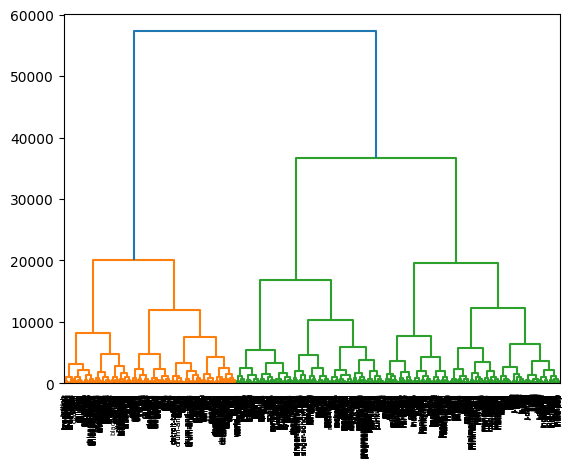

In [ ]:
dn = dendrogram(linkage_matrix, labels=data['track_genre'].iloc[sample_tf.index].values)

To find the optimal number of clusters the elbow method is used. This method involves drawing a horizontal line through different parts of the dendrogram and finding the line that has the most intersections with the dendogram. This would be the optimal nunmber of clusters for hierarchical clustering.

In [ ]:
last_distances = linkage_matrix[-3000:, 2]

In [ ]:
distance_diffs = np.diff(last_distances)

In [ ]:
elbow_point = np.argmax(distance_diffs) + 1

In [ ]:
optimal_clusters = 3000 - elbow_point

In [ ]:
optimal_clusters = 7

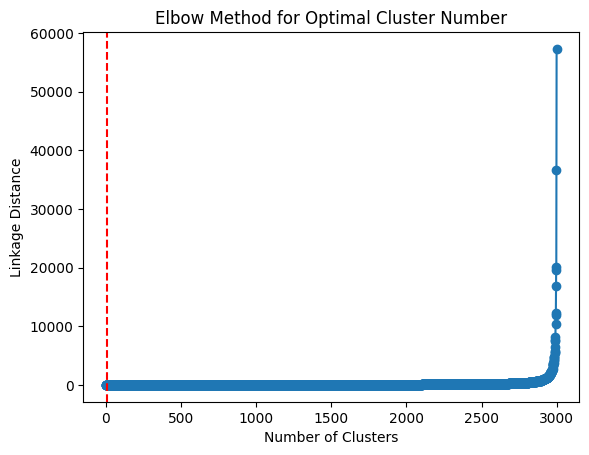

In [ ]:
plt.plot(range(1, len(last_distances) + 1), last_distances, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Linkage Distance')
plt.title('Elbow Method for Optimal Cluster Number')
plt.axvline(x=optimal_clusters, color='r', linestyle='--')
plt.show()


In [22]:
clusterer = hdbscan.HDBSCAN()

In [23]:
labels = clusterer.fit_predict(sample)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


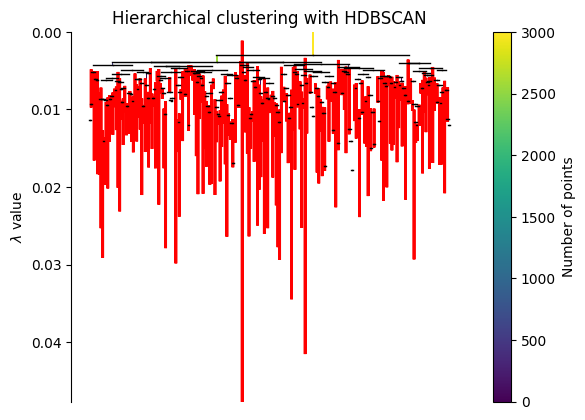

In [25]:
clusterer.condensed_tree_.plot(select_clusters=True, colorbar=True)
plt.title('Hierarchical clustering with HDBSCAN')
plt.show()